In [1]:
#making figures for the AIML conference, based on ACE heavily, but need to do some modifications or additional things
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import pandas as pd
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
#some other things to load in
import numpy as np
genome = np.load('/data1/lesliec/sarthak/data/chrombpnet_test/hg38_tokenized.npz')
genome_loaded = {}
for key in genome:
    genome_loaded[key] = genome[key][:]

bims = {}
for i in range(1,23):
    bim_path = f'/data1/deyk/extras/1000G_BIMS_hg38/1000G.EUR.QC.{i}.bim'
    bim = pd.read_csv(bim_path, sep='\t', header=None)
    bims[i] = bim
    
bim_pos = {
    chrom: dict(zip(bims[chrom][1].values, bims[chrom][3].index))
    for chrom in bims
}
bim_pos #just maps the rsid and chromosome to the index in the bim file
#now we can load our model in
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path, device=1)
#now what we do is we loop through, get the positions, then we can evaluate it

# qtls.iloc[0]
rsid = qtls.iloc[0]['SNPname2']
chrom = qtls.iloc[0]['chrom_hg19']
bimrow = bim_pos[int(chrom[3:])][rsid]
bimval = bims[int(chrom[3:])].iloc[bimrow]
bimval
# (qtls['chrom_hg19'] == qtls['chrom_hg18']).value_counts() #good at least the chromosome matches lol, and a single mismatch with hg38 bims, but it's fine!
midpoint = bimval[3]-1
start = midpoint - 524288//2
end = start + 524288
# chrom = bimval[0]
print(start,end,chrom)



JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
714070 1238358 chr1


In [2]:
#so we have the position now, but we want many cell types and tracks...

idx = evals.dataset.expand_seqs(chrom,start,end)
data = evals.dataset[idx]
# data[0][0].shape, data[0][1].shape, data[1][0].shape, data[1][1].shape
si = 524288//2 - 250
se = 524288//2 + 250
out = evals.mask(si,se, idx, mask_accessibility=True)


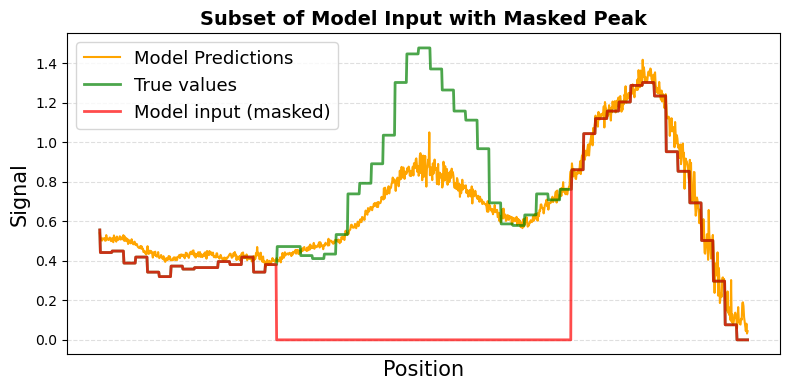

In [4]:

fig, ax = plt.subplots(figsize=(8, 4))

# Plot both lines with alpha for clarity
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
ax.plot(out[-3][si-300:se+300, 0], label='True values', color='green', linewidth=2, alpha=0.7)
ax.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input (masked)', color='red', linewidth=2, alpha=0.7)

# Shade the masked region
mask_start = 300
mask_end = 300 + (se - si)
# ax.axvspan(mask_start, mask_end, color='gray', alpha=0.2, label='Masked region')

# Axis styling
ax.set_xlabel('Position', fontsize=15)
ax.set_ylabel('Signal', fontsize=15)
ax.set_title('Subset of Model Input with Masked Peak', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=13)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

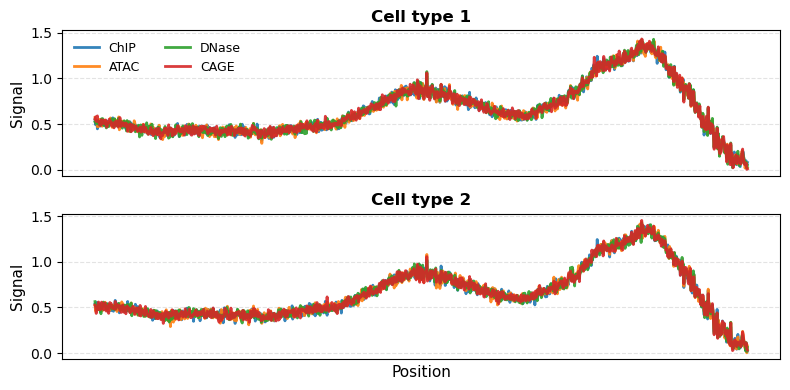

In [18]:
#you know, it would be quite easy if we just had the predictions stored somewhere, but we definitely don't...

#let's just generate some noise and use it to reshape or modify this region

import numpy as np
import matplotlib.pyplot as plt

# --- pick your base predictions (1D arrays over the region you want) ---
# example using your tensors; adjust indexing to match your shapes
base_ct1 = out[1][0, si-300:se+300, 0].detach().cpu().numpy()
base_ct2 = out[1][0, si-300:se+300, 0].detach().cpu().numpy()  # or reuse ct1 if you only have one

rng = np.random.default_rng(42)
noise_scale = .1  # ~5% of std; tweak as needed
n_tracks = 4

fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)

track_labels = ['ChIP', 'ATAC', 'DNase', 'CAGE']

# ----- Cell type 1 -----
ax = axes[0]
for i in range(n_tracks):
    noise = rng.normal(0, noise_scale * (base_ct1.std() + 1e-8), size=base_ct1.shape)
    ax.plot(base_ct1 + noise, label=track_labels[i], linewidth=2, alpha=0.9)
ax.set_title('Cell type 1', fontsize=12, fontweight='bold')
ax.set_ylabel('Signal', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.legend(loc='upper left', fontsize=9, ncol=2, frameon=False)

# ----- Cell type 2 -----
ax = axes[1]
for i in range(n_tracks):
    noise = rng.normal(0, noise_scale * (base_ct2.std() + 1e-8), size=base_ct2.shape)
    ax.plot(base_ct2 + noise, label=f'Track {i+1}', linewidth=2, alpha=0.9)
ax.set_title('Cell type 2', fontsize=12, fontweight='bold')
ax.set_xlabel('Position', fontsize=11)
ax.set_ylabel('Signal', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.35)

# clean x ticks (optional)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.show()



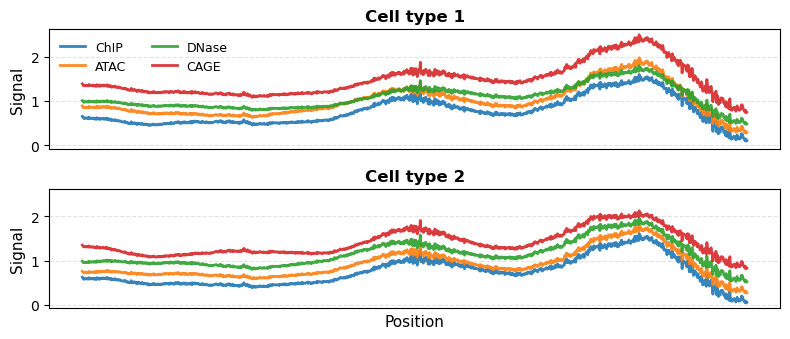

In [41]:
# more distinct tracks

# you know, it would be quite easy if we just had the predictions stored somewhere, but we definitely don't...
# let's just generate some noise and use it to reshape or modify this region

import numpy as np
import matplotlib.pyplot as plt

# --- pick your base predictions (1D arrays over the region you want) ---
# example using your tensors; adjust indexing to match your shapes
base_ct1 = out[1][0, si-300:se+300, 0].detach().cpu().numpy()
base_ct2 = out[1][0, si-300:se+300, 0].detach().cpu().numpy()  # or reuse ct1 if you only have one

rng = np.random.default_rng(420)
n_tracks = 4

def make_distinct_tracks(base, n_tracks=4, rng=None):
    base = np.asarray(base)
    std = base.std() + 1e-8

    if rng is None:
        rng = np.random.default_rng(0)

    tracks = []
    for i in range(n_tracks):
        # start with a copy
        y = base.copy()

        # 1. scaling + shifting (baseline separation)
        scale = 1.0 + rng.uniform(-0.15, 0.15)
        shift = rng.uniform(-0.3, 0.3) * std
        y = y * scale + shift + i*0.25

        # 2. random smooth distortion (local warping)
        warp = np.linspace(0, 2*np.pi, len(y)) * 2
        y = y * (1.0 + 0.05 * np.sin(warp * rng.uniform(0.5, 2.0) + rng.uniform(0, 2*np.pi)))

        # 3. optional smoothing/sharpening
        y = np.sign(y) * (np.abs(y) ** 1.1)

        # 4. structured noise (low-frequency)
        raw_noise = rng.normal(0, 0.02 * std, size=len(y))
        kernel = np.ones(100) / 100
        smooth_noise = np.convolve(raw_noise, kernel, mode='same')
        y = y + smooth_noise

        tracks.append(y)

    return tracks


fig, axes = plt.subplots(2, 1, figsize=(8, 3.5), sharex=True, sharey=True)

track_labels = ['ChIP', 'ATAC', 'DNase', 'CAGE']

# ----- Cell type 1 -----
ax = axes[0]
tracks1 = make_distinct_tracks(base_ct1, n_tracks=n_tracks, rng=rng)
for i, tr in enumerate(tracks1):
    ax.plot(tr, label=track_labels[i], linewidth=2, alpha=0.9)
ax.set_title('Cell type 1', fontsize=12, fontweight='bold')
ax.set_ylabel('Signal', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.legend(loc='upper left', fontsize=9, ncol=2, frameon=False)

# ----- Cell type 2 -----
ax = axes[1]
tracks2 = make_distinct_tracks(base_ct2, n_tracks=n_tracks, rng=rng)
for i, tr in enumerate(tracks2):
    ax.plot(tr, label=f'Track {i+1}', linewidth=2, alpha=0.9)
ax.set_title('Cell type 2', fontsize=12, fontweight='bold')
ax.set_xlabel('Position', fontsize=11)
ax.set_ylabel('Signal', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.35)

# clean x ticks (optional)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.show()


# figure 3

The QTL benchmarks

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_3480908/661394465.py:104: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


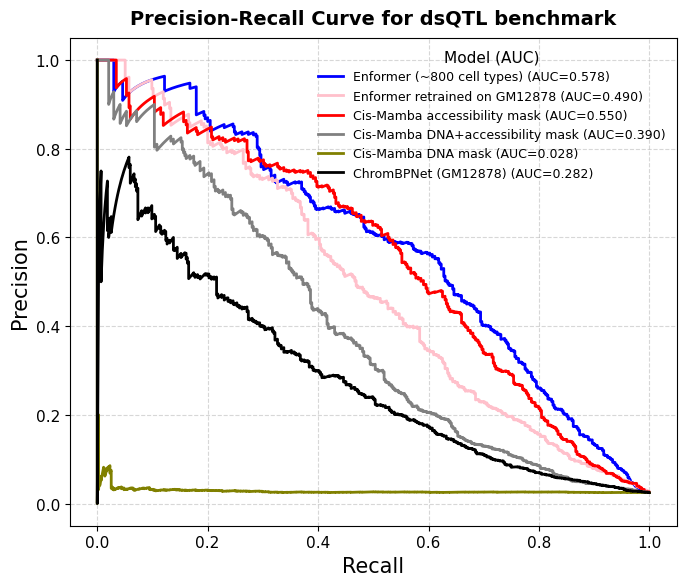

In [5]:
# ok this will be slightly annoying...

#we will include the major models, we will not add in alpha genome. 

#let's go ahead and make this one with the dsQTL results


#want to use the same models that we trained with eQTL

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2



qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

def predict_snp_effect_scores_bpnet(ref_prob_preds, alt_prob_preds, ref_count_preds, alt_count_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    
    print(ref_prob_preds.shape, alt_prob_preds.shape, ref_count_preds.shape, alt_count_preds.shape)
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    #and account for nan
    log_probs_diff_abs_sum[np.isnan(log_probs_diff_abs_sum)] = 0
    # probs_jsd_diff = np.array([jensenshannon(softmax(x),softmax(y)) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    probs_jsd_diff = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(alt_prob_preds),
                                    softmax(ref_prob_preds))])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_count_preds/alt_count_preds)[:,0]
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2
    
labels = qtls['label'].to_numpy()

#A slightly different version where we don't use mamba 8 cell types but isntead use Enformer on 1 cell type

#make it look better
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'pink', 'red', 'gray', 'olive', 'black', 'pink', 'gray', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=9,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()

files = ['enformer_dsqtl.npy', 'enformer_dsqtl_retrained-dsqtl.npy', 'nomlm_maskonly.npy', 'base_dsqtl_mask_1000.npy', 'gm12878_noacc_.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Enformer retrained on GM12878', 'Cis-Mamba accessibility mask', 'Cis-Mamba DNA+accessibility mask', 'Cis-Mamba DNA mask',
                     'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

In [1]:
#That's a, now let's do b and c

import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)



(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True
Processing enformer with shape (1937, 896)


100%|██████████| 1937/1937 [00:02<00:00, 863.32it/s] 


Processing GM12878_no_mlm_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1061.43it/s]


Processing immune_CAGE_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1067.58it/s]


Processing nopretrain_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1065.38it/s]


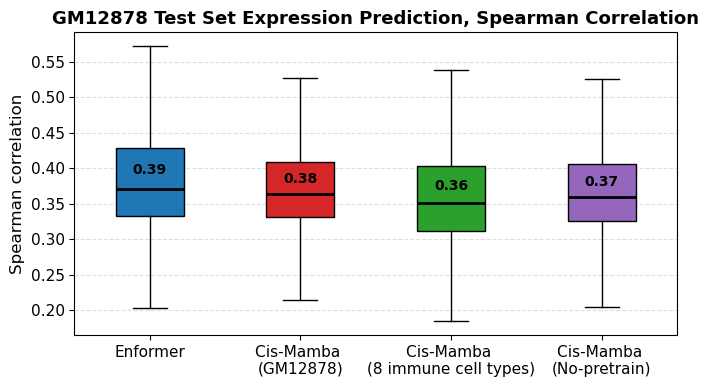

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Desired order of models (match keys in spearman_results)
ordered_keys = [
    'enformer',
    'GM12878_no_mlm_predictions.npy',
    'immune_CAGE_predictions.npy',
    'nopretrain_predictions.npy'
]

# Pretty display labels
pretty_labels = [
    'Enformer',
    'Cis-Mamba \n(GM12878)',
    'Cis-Mamba \n(8 immune cell types)',
    'Cis-Mamba \n(No-pretrain)'
]

# Matching colors (same order)
colors = ['#1f77b4',  # blue
          '#d62728',  # red
          '#2ca02c',  # green
          '#9467bd']  # purple

# Pull data in correct order
data = [spearman_results[k] for k in ordered_keys]

# Plot
plt.figure(figsize=(7, 4))
box = plt.boxplot(data, labels=pretty_labels, showfliers=False, patch_artist=True,
                  boxprops=dict(edgecolor='black'),
                  medianprops=dict(color='black', linewidth=2),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'))

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Annotate mean values on each box
for i, vals in enumerate(data):
    mean_val = np.mean(vals)
    plt.text(i + 1, mean_val, f"{mean_val:.2f}",  # slight offset above median
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and formatting
plt.ylabel("Spearman correlation", fontsize=12)
plt.title("GM12878 Test Set Expression Prediction, Spearman Correlation", fontsize=13, weight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


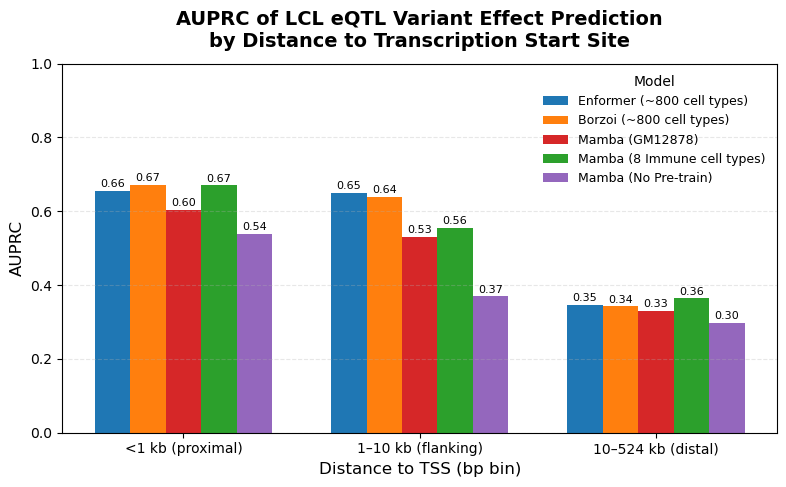

In [11]:
#and let's do the last one

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()


qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=False, title='', mask=None):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        if center:
            center_start = eqtl_data.shape[1] // 2 - center[i] // 2
            center_end = center_start + center[i]
            eqtl_data = eqtl_data[:, center_start:center_end, :]
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if mask is None: #can supply a mask or can use default mask of the first value!
            if i == 0:
                non_zero_mask = (out[0] != 0)
        else:
            non_zero_mask = mask

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name} {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()
    
import pickle
base_dir = '/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/'
with open(base_dir+'genes.pickle', 'rb') as f:
    gene_annotation = pickle.load(f)

ordered_genes = sorted(list(gene_annotation.keys()))

tmpgeneTSS = np.loadtxt(base_dir+'ensemblTSS.txt', dtype='str')
geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}

distances = np.zeros((qtls.shape[0],), dtype=int)

for i in range(qtls.shape[0]):
    #initialize values and load in data
    temp = qtls.iloc[i]
    chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
    pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
    gene_idx= temp['gene_idx']
    tss_loc = geneTSS_dic[ordered_genes[gene_idx]]
    # print(tss_loc, pos)
    distances[i] = abs(tss_loc - pos)    
    


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

files = ['enformer_eqtl.npy', 'borzoi_eqtl.npy', 'nomlm_maskonly.npy', 'immune.npy', 'nopretrain.npy']
center = [16, 16*4, 16, 16, 16, 16, 16, 16]
# --- your thresholds & names ---
thresholds       = [1_000, 10_000, 524_288]
threshold_names  = ['<1 kb (proximal)', '1–10 kb (flanking)', '10–524 kb (distal)']
model_files      = files
model_labels     = ['Enformer (~800 cell types)', 'Borzoi (~800 cell types)', 'Mamba (GM12878)',
                    'Mamba (8 Immune cell types)', 'Mamba (No Pre-train)']
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors[5] = 'pink'
colors = ['#1f77b4',  # blue
          '#ff7f0e',  # orange
          '#d62728',  # red
          '#2ca02c',  # green
          '#9467bd']  # purple

# --- compute AUPRC matrix ---
auprc_by_threshold = []
for thr in thresholds:
    if thr == 1_000:
        mask = distances < thr
    elif thr == 10_000:
        mask = (distances >= 1_000) & (distances < thr)
    else:
        mask = (distances >= 10_000) & (distances < thr)

    row = []
    for i, fname in enumerate(model_files):
        data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{fname}')
        cs = data.shape[1] // 2 - center[i] // 2
        ce = cs + center[i]
        eqtl = data[:, cs:ce, :]
        out  = predict_snp_effect_scores(eqtl[:, :, 0], eqtl[:, :, 1])
        scores = np.abs(out[0])[mask]  # logFC metric
        pr, rc, _ = precision_recall_curve(labels[mask], scores)
        row.append(auc(rc, pr))
    auprc_by_threshold.append(row)
auprc = np.array(auprc_by_threshold)  # shape (3,5)

# --- plotting ---
x         = np.arange(len(thresholds))
bar_width = 0.15

plt.figure(figsize=(8, 5))
for i, label in enumerate(model_labels):
    plt.bar(x + i*bar_width,
            auprc[:, i],
            width=bar_width,
            label=label,
            color=colors[i % len(colors)])

# Annotate bar heights
for i in range(len(thresholds)):
    for j in range(len(model_labels)):
        y = auprc[i, j]
        plt.text(x[i] + j*bar_width, y + 0.005,
                 f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Styling
plt.xticks(x + (len(model_labels)-1)/2*bar_width, threshold_names, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.xlabel('Distance to TSS (bp bin)', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)
plt.title('AUPRC of LCL eQTL Variant Effect Prediction\nby Distance to Transcription Start Site', 
          fontsize=14, fontweight='bold', pad=12)

# leg = plt.legend(title='Model', fontsize=9, title_fontsize=10,
#                  bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
leg = plt.legend(title='Model', fontsize=9, title_fontsize=10, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

# figure 4

TThe results compared to the gLMs

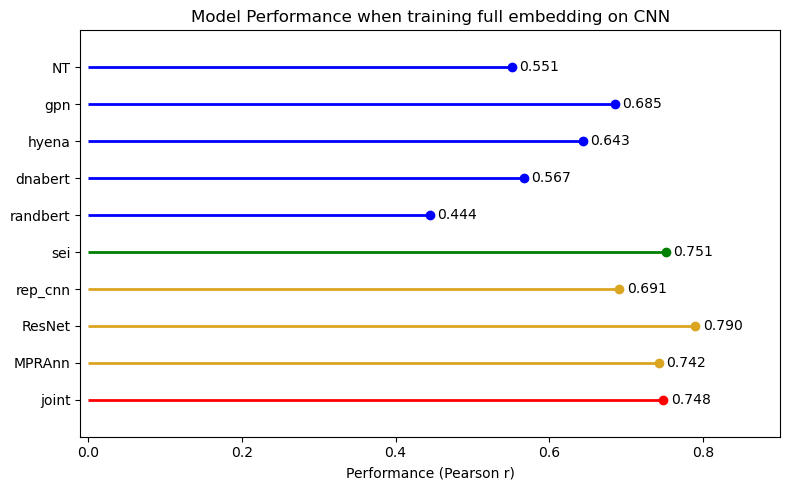

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
other_results = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/koo_benchmark/LLM_CNN.csv')
other_results = other_results[other_results['Cell Type'] == 'K562']
#now remove models CNN0.5 and CNN 1.0
other_results = other_results[~other_results['Model'].str.contains('CNN0.5')]
other_results = other_results[~other_results['Model'].str.contains('CNN1.0')]
#now let's add our own
out = 0.7484
new_row = pd.DataFrame({'Model': ['CNN2.0'], 'Cell Type': ['K562'], 'Performance': [out], 'LLM': ['joint']})
other_results = pd.concat([other_results, new_row], ignore_index=True)
out = 0.5513
new_row = pd.DataFrame({'Model': ['CNN2.0'], 'Cell Type': ['K562'], 'Performance': [out], 'LLM': ['NT']})
other_results = pd.concat([other_results, new_row], ignore_index=True)


order = [9,4,6,5,7,0,2,1,3,8][::-1]
df_ordered = other_results.loc[order].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 5))
n = len(df_ordered)

for i, (llm, perf) in enumerate(zip(df_ordered['LLM'], df_ordered['Performance'])):
    # determine color by “visual” position: top-down
    if i >= n - 5:
        color = 'blue'         # top 4
    elif i == n - 6:
        color = 'green'        # next 1
    elif i >= n - 9:
        color = 'goldenrod'    # next 3 (darker yellow)
    else:
        color = 'red'          # final 1

    ax.hlines(y=i, xmin=0, xmax=perf, linewidth=2, color=color)
    ax.plot(perf, i, 'o', color=color)
    ax.text(perf + 0.01, i, f"{perf:.3f}", va='center')

ax.set_yticks(range(n))
ax.set_yticklabels(df_ordered['LLM'])
ax.set_xlabel('Performance (Pearson r)')
ax.set_xlim(-0.01, 0.9)
ax.set_ylim(-1, n)
ax.set_title('Model Performance when training full embedding on CNN')
plt.tight_layout()
plt.show()

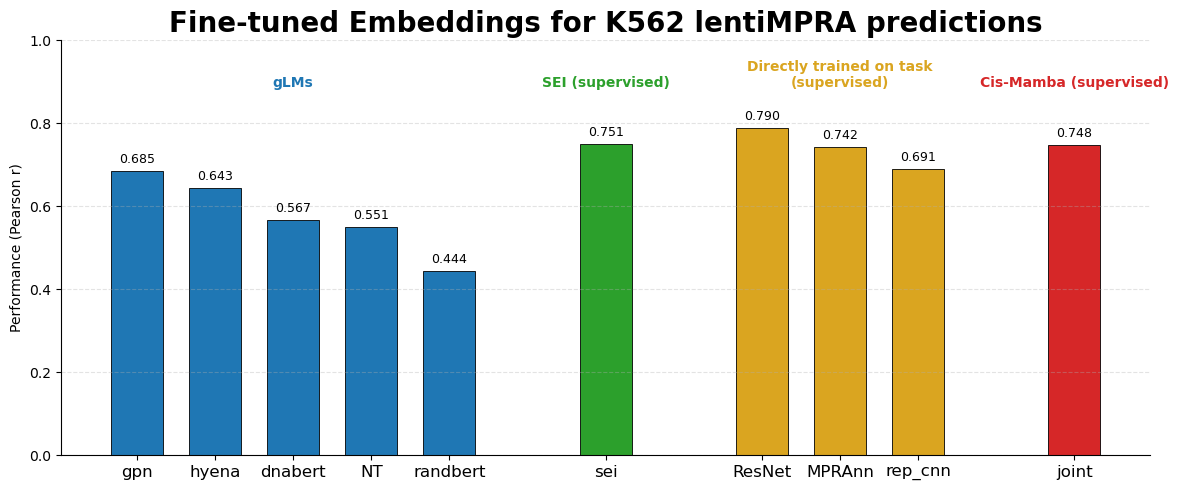

In [32]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- your existing loading / filtering ---
other_results = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/koo_benchmark/LLM_CNN.csv')
other_results = other_results[other_results['Cell Type'] == 'K562']
other_results = other_results[~other_results['Model'].str.contains('CNN0.5')]
other_results = other_results[~other_results['Model'].str.contains('CNN1.0')]

# add your two rows (keep your labels)
df = other_results.copy()
df = pd.concat([
    df,
    pd.DataFrame({'Model': ['CNN2.0'], 'Cell Type': ['K562'], 'Performance': [0.7484], 'LLM': ['joint']}),  # Cis-Mamba
    pd.DataFrame({'Model': ['CNN2.0'], 'Cell Type': ['K562'], 'Performance': [0.5513], 'LLM': ['NT']})      # NT baseline
], ignore_index=True)

# --- categorize rows into groups -> color them ---
# EDIT these sets/patterns to match your file exactly.
glms = {'NT', 'DNABERT', 'Nucleotide Transformer', 'HyenaDNA', 'GENA-LM', 'Evo', 'gpn', 'hyena', 'randbert'}
sei_names = {'SEI'}
task_specific = {'Enformer', 'Borzoi', 'ChromBPNet', 'CNN2.0', 'CNN'}  # generic supervised

def is_match(name, choices):
    return any(c.lower() in name.lower() for c in choices)

def assign_group(row):
    model = str(row.get('Model', ''))
    llm   = str(row.get('LLM', ''))
    # Your Cis-Mamba: mark the joint run as Cis-Mamba
    if llm.lower() == 'joint':
        return 'cis_mamba'
    # SEI (supervised)
    if is_match(model, sei_names) or is_match(llm, sei_names):
        return 'sei'
    # gLMs (sequence-only pretraining)
    if (llm in glms) or is_match(llm, glms) or is_match(model, glms):
        return 'glm'
    # Everything else -> supervised task-specific baseline
    return 'task'

df['Group'] = df.apply(assign_group, axis=1)

# optional: nice display name per bar (short + unambiguous)
def short_name(row):
    m = str(row['Model'])
    l = str(row['LLM'])
    # collapse long LLM names
    if l.lower() == 'nucleotide transformer': l = 'NT'
    return f"{l}" if l and l.lower() not in ['nan', ''] else m
df['Label'] = df.apply(short_name, axis=1)

# Sort bars by group, then by performance (desc) within group
group_order = ['glm', 'sei', 'task', 'cis_mamba']
df['Group'] = pd.Categorical(df['Group'], categories=group_order, ordered=True)
df = df.sort_values(['Group', 'Performance'], ascending=[True, False]).reset_index(drop=True)

# Colors per group
colors = {
    'glm':       '#1f77b4',  # blue
    'task':      '#DAA520',  # goldenrod / yellow
    'sei':       '#2ca02c',  # green
    'cis_mamba': '#d62728',  # red
}

# --- compute x positions with extra gaps between groups ---
bar_width      = 0.8
intra_spacing  = 0.4  # space between bars inside a group
inter_gap      = 1.2  # extra gap between groups

xpos = []
group_ticks = []   # (center_x, name) for group labels
current_x = 0.0

for g in group_order:
    sub = df[df['Group'] == g]
    if sub.empty:
        continue
    start = current_x
    for _ in range(len(sub)):
        xpos.append(current_x)
        current_x += bar_width + intra_spacing
    end = current_x - (bar_width + intra_spacing)  # last bar x
    group_center = (start + end) / 2 if start != end else start
    group_ticks.append((group_center, g))
    current_x += inter_gap  # add big gap before next group

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

for (i, row), x in zip(df.iterrows(), xpos):
    ax.bar(x, row['Performance'], width=bar_width, color=colors[row['Group']], edgecolor='black', linewidth=0.6)
    ax.text(x, row['Performance'] + 0.012, f"{row['Performance']:.3f}", ha='center', va='bottom', fontsize=9)

# x tick labels under each bar
ax.set_xticks(xpos)
ax.set_xticklabels(df['Label'], rotation=0, ha='center', fontsize=12)

ax.set_ylabel('Performance (Pearson r)')
ax.set_ylim(0, 1)
ax.set_title('Fine-tuned Embeddings for K562 lentiMPRA predictions', fontsize=20, weight='bold')

# group labels above the groups
for center, g in group_ticks:
    name = {'glm': 'gLMs', 'task': 'Directly trained on task\n(supervised)', 'sei': 'SEI (supervised)', 'cis_mamba': 'Cis-Mamba (supervised)'}[g]
    ax.text(center, ax.get_ylim()[1]-.12, name, ha='center', va='bottom',
            fontsize=10, weight='bold', color=colors[g], transform=ax.transData, clip_on=False)

# clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()
